In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from transformers import BertTokenizer ,BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import spacy
import torch.nn as nn
import torch.optim as optim
from torch.hub import load
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsRegressor





In [2]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load dataset
file_path = 'full_format_recipes.json' 
data = pd.read_json(file_path)
data.dropna(inplace=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)



In [4]:

# Basic exploration
print(f"Dataset shape: {data.shape}")
print("Columns:", data.columns)

Dataset shape: (10608, 11)
Columns: Index(['directions', 'fat', 'date', 'categories', 'calories', 'desc',
       'protein', 'rating', 'title', 'ingredients', 'sodium'],
      dtype='object')


In [5]:
# Focus on relevant columns
StringData = data[['directions', 'desc', 'rating','categories','title']].copy()

StringDataWithNames=data[['directions', 'desc', 'rating','categories','title']].copy()






In [6]:
# Handle nested structures and add column names before each value
string_columns = ['directions', 'categories', 'desc', 'title']

for col in string_columns:
    StringDataWithNames[col] = StringDataWithNames[col].apply(
        lambda x: f"{col}: {', '.join(map(str, x))}" if isinstance(x, (list, np.ndarray)) else f"{col}: {x}" if pd.notnull(x) else x
    )


# Combine text features into one

# Ensure all values are strings before concatenation
StringDataWithNames['Alltext'] = StringDataWithNames['directions'].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
) + " [SEP] " + StringDataWithNames['categories'].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
) + " [SEP] " + StringDataWithNames['desc'].apply(
    lambda x: str(x)
) + " [SEP] " + StringDataWithNames['title'].apply(
    lambda x: str(x)
)




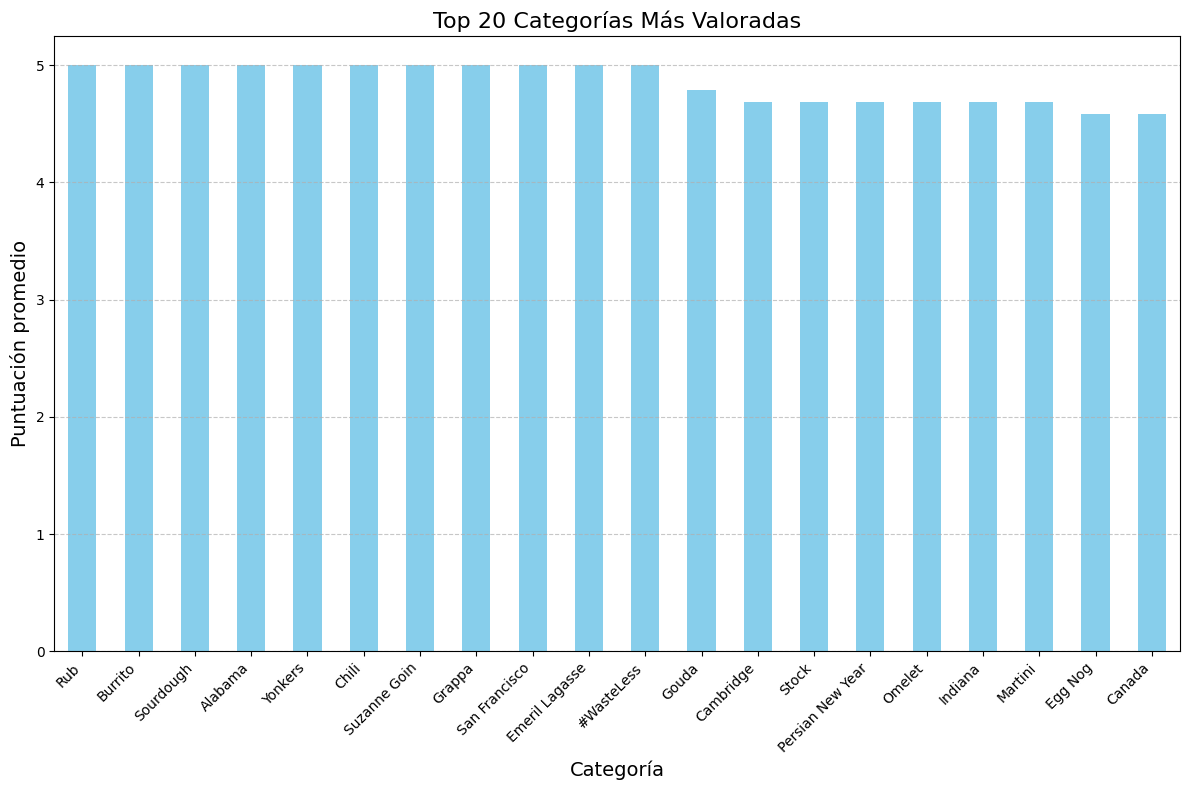

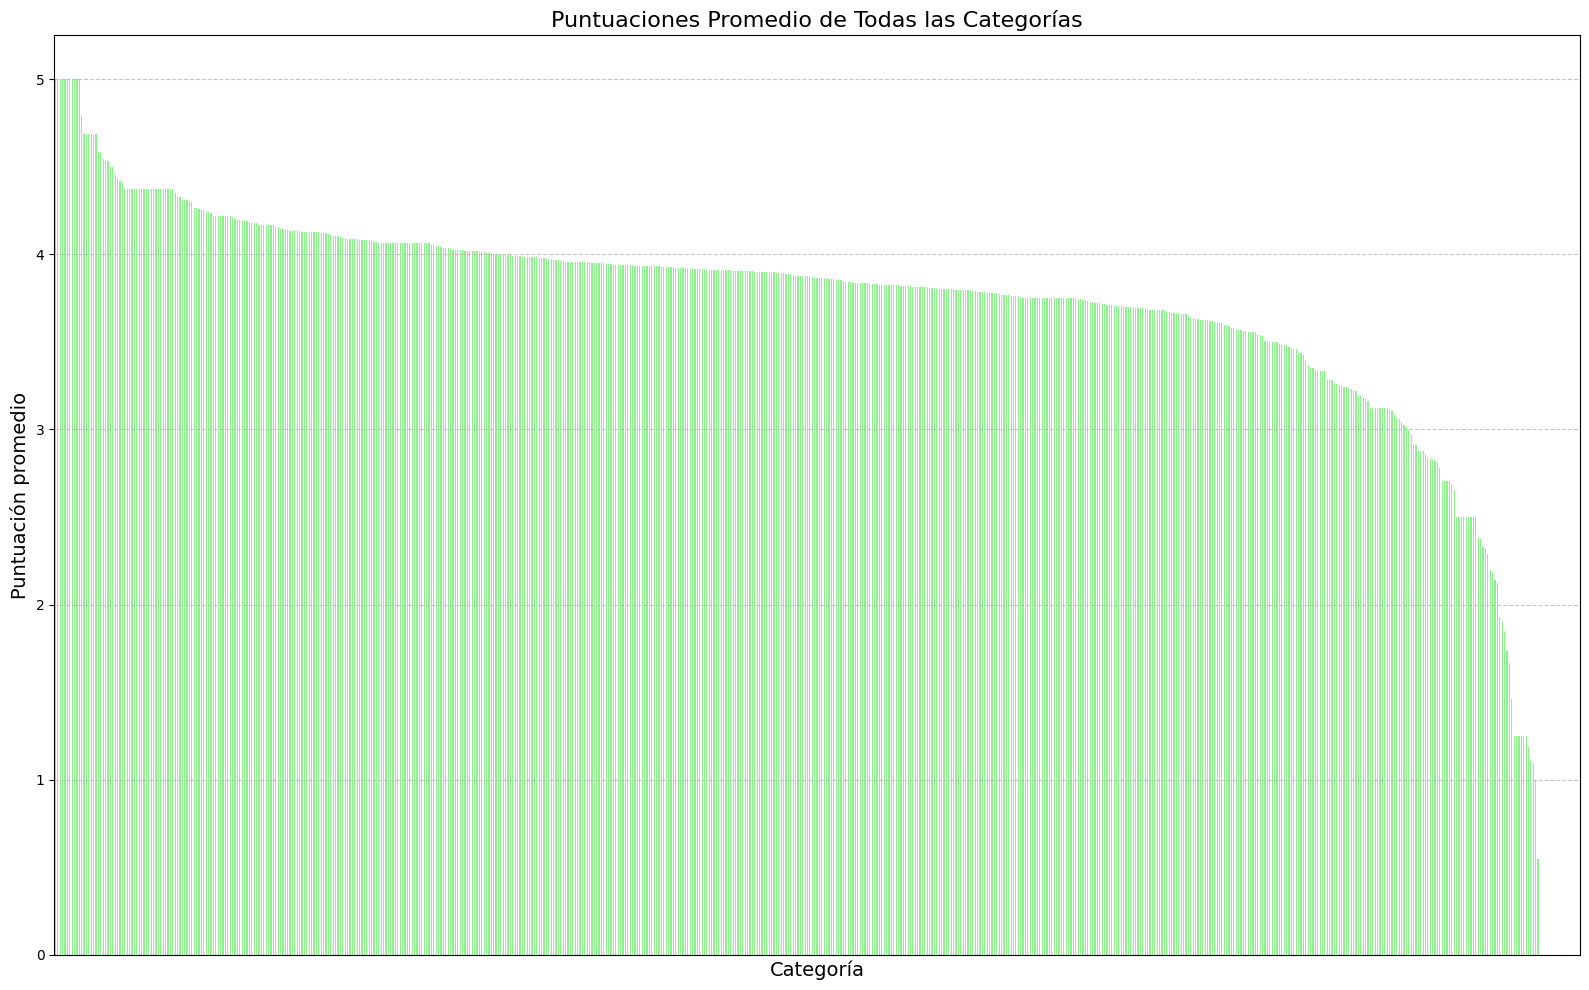

Número total de categorías únicas: 637


In [7]:


# Explode the 'categories' column and calculate mean ratings for each category
categories_exploded = data.explode('categories')
category_ratings = categories_exploded.groupby('categories')['rating'].mean().sort_values(ascending=False)

# Plot the top 20 categories
plt.figure(figsize=(12, 8))
category_ratings.head(20).plot(kind='bar', color='skyblue')
plt.title('Top 20 Categorías Más Valoradas', fontsize=16)
plt.xlabel('Categoría', fontsize=14)
plt.ylabel('Puntuación promedio', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot all categories without x-axis labels
plt.figure(figsize=(16, 10))
category_ratings.plot(kind='bar', color='lightgreen')
plt.title('Puntuaciones Promedio de Todas las Categorías', fontsize=16)
plt.xlabel('Categoría', fontsize=14)
plt.ylabel('Puntuación promedio', fontsize=14)
plt.xticks([])  # Removes x-axis labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display the total number of unique categories
categorias_unicas = categories_exploded['categories'].nunique()
print(f"Número total de categorías únicas: {categorias_unicas}")




In [8]:
# Text preprocessing function
nlp = spacy.load('en_core_web_sm')
def preprocess_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])


In [9]:


# Apply preprocessing
StringData['processed_directions'] = StringData['directions'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))
StringData['processed_desc'] = StringData['desc'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))
StringData['processed_categories'] = StringData['categories'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))
StringData['processed_title'] = StringData['title'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))







In [10]:
# Extract and normalize numeric features
numeric_features = data[['fat', 'protein', 'calories', 'sodium']]
scaler = StandardScaler()
numeric_features = scaler.fit_transform(numeric_features)

In [11]:
print(StringData[['processed_directions', 'processed_desc', 'processed_categories', 'processed_title']].head())

                                processed_directions  \
0  simmer pea cream red pepper flake garlic teasp...   
1  Combine sugar orange juice concentrate water h...   
2  preheat oven F Butter flour cup Bundt pan Whis...   
3  heat peanut oil heavy large pot medium high he...   
4  stir ingredient small bowl blend season taste ...   

                                      processed_desc  \
0  zing fresh lemon enhance pea sweetness natural...   
1           Orange syrup sweeten cake fresh fruit go   
2  brandied whip cream add perfect finishing touc...   
3  hearty stew like soup inspire vietnamese pho h...   
4                                 nice toasted bagel   

                                processed_categories  \
0  Milk Cream Pasta Christmas Vegetarian Quick Ea...   
1  chocolate Dessert Bake Passover Orange Date Wa...   
2  Cake Fruit Dessert Currant Orange Pineapple Al...   
3  Soup Stew Beef Sauté Dinner Lunch Spring Noodl...   
4  Condiment Spread Dairy fish Herb Breakfast 

--------------------------------------------------------------------TF-IDF------------------------------------------------------------------

In [12]:
# TF-IDF vectorization for individual columns
vectorizer = TfidfVectorizer(max_features=100)
categories_tfidf = vectorizer.fit_transform(StringData['processed_categories'])
desc_tfidf = vectorizer.fit_transform(StringData['processed_desc'])
directions_tfidf = vectorizer.fit_transform(StringData['processed_directions'])
title_tfidf = vectorizer.fit_transform(StringData['processed_title'])

In [13]:
#Convert data to X and Y combining numeric and written features
X_TFIDF = torch.tensor(
    pd.concat(
        [pd.DataFrame(categories_tfidf.toarray()), pd.DataFrame(desc_tfidf.toarray()), pd.DataFrame(directions_tfidf.toarray()), pd.DataFrame(title_tfidf.toarray()), pd.DataFrame(numeric_features)],
        axis=1
    ).values,
    dtype=torch.float32
)
y = torch.tensor(data['rating'].values, dtype=torch.float32)  # Target variable

In [14]:
# Train-test-validation split
X_train_TFIDF, X_test_TFIDF, y_train, y_test = train_test_split(
   X_TFIDF, y, test_size=0.2, random_state=42)

X_val_TFIDF, X_test_TFIDF, y_val, y_test = train_test_split(
    X_test_TFIDF, y_test, test_size=0.5, random_state=42)  

--------------------------------------------------------------------WORD2VEC------------------------------------------------------------------

In [15]:
# Prepare data for Word2Vec
documents = StringData['processed_directions'].tolist() + StringData['processed_desc'].tolist() + \
            StringData['processed_categories'].tolist() + StringData['processed_title'].tolist()
tokenized_documents = [doc.split() for doc in documents]



In [16]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_documents, vector_size=100, window=5, min_count=1, workers=4)

In [17]:
# Function to calculate document embeddings
def get_doc_embedding(doc, model):
    words = doc.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


In [18]:

# Generate Word2Vec embeddings for each column
StringData['directions_w2v'] = StringData['processed_directions'].apply(lambda x: get_doc_embedding(x, word2vec_model))
StringData['desc_w2v'] = StringData['processed_desc'].apply(lambda x: get_doc_embedding(x, word2vec_model))
StringData['categories_w2v'] = StringData['processed_categories'].apply(lambda x: get_doc_embedding(x, word2vec_model))
StringData['title_w2v'] = StringData['processed_title'].apply(lambda x: get_doc_embedding(x, word2vec_model))


In [19]:

# Combine Word2Vec embeddings into a single feature matrix
w2v_features = np.array(StringData['directions_w2v'].tolist()) + \
               np.array(StringData['desc_w2v'].tolist()) + \
               np.array(StringData['categories_w2v'].tolist()) + \
               np.array(StringData['title_w2v'].tolist())


In [20]:
#Convert data to X and Y combining numeric and written features
X_W2V = torch.tensor(
    pd.concat(
        [pd.DataFrame(w2v_features), pd.DataFrame(numeric_features)],
        axis=1
    ).values,
    dtype=torch.float32
)
y = torch.tensor(data['rating'].values, dtype=torch.float32)  # Target variable

#
# final_features = np.hstack([w2v_features, numeric_features])


In [21]:
# Train-test split
X_train_W2V, X_test_W2V, y_train, y_test = train_test_split(
   X_W2V, y, test_size=0.2, random_state=42)
X_val_W2V, X_test_W2V, y_val, y_test = train_test_split(
    X_test_W2V, y_test, test_size=0.5, random_state=42)  

--------------------------------------------------------------------BERT------------------------------------------------------------------

In [22]:

# Using BERT embeddings for contextual embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


In [23]:
def get_bert_embeddings(text_list):
    tokens = tokenizer(text_list, padding=True, truncation=True, max_length=64, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
    # Use the CLS token embeddings as the document representation
    return outputs.last_hidden_state[:, 0, :].numpy()



In [24]:
#X_text_Prebert = StringDataWithNames['Alltext']
#X_embeddings = get_bert_embeddings(X_text_Prebert.tolist())
embeddings_directions = get_bert_embeddings(StringDataWithNames['directions'].tolist())
embeddings_desc = get_bert_embeddings(StringDataWithNames['desc'].tolist())
embeddings_categories = get_bert_embeddings(StringDataWithNames['categories'].tolist())
embeddings_title = get_bert_embeddings(StringDataWithNames['title'].tolist())

# Stack all features together
X_embeddings = np.hstack([
    embeddings_directions,
    embeddings_desc,
    embeddings_categories,
    embeddings_title,
    numeric_features
])





In [25]:
# Combine BERT embeddings and numeric features
X_BERT = torch.tensor(
    pd.concat(
        [pd.DataFrame(X_embeddings), pd.DataFrame(numeric_features)],
        axis=1
    ).values,
    dtype=torch.float32
)
y = torch.tensor(data['rating'].values, dtype=torch.float32)  # Target variable

In [26]:
# Split BERT
X_train_bert, X_test_bert, y_train, y_test = train_test_split(
    X_BERT, y, test_size=0.2, random_state=42)

X_val_bert, X_test_bert, y_val, y_test = train_test_split(
    X_test_bert, y_test, test_size=0.5, random_state=42)

-----------------------------------------------------------------------------Before Starting---------------------------------------------------------------------

In [27]:

# Calculate the mean of the 'rating' feature
mean_rating = StringData['rating'].mean()

# Create a prediction array with the mean value for all samples
predictions = np.full_like(StringData['rating'], mean_rating)

# Calculate the MAE
mae = mean_absolute_error(StringData['rating'], predictions)

print(f"Mean rating: {mean_rating}")
print(f"MAE when predicting the mean: {mae}")

Mean rating: 3.8045578808446456
MAE when predicting the mean: 0.828418629242508


--------------------------------------------------------------------KNN------------------------------------------------------------------

In [28]:

knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_TFIDF, y_train)

KNeighborsRegressor()

In [29]:
# Ensure X_test and y_test are numpy arrays
#X_test_bert_np = X_train_bert.cpu().numpy() if isinstance(X_train_bert, torch.Tensor) else X_train_bert
#y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test

# Predictions and evaluation
knn_predictions = knn_model.predict(X_test_TFIDF)
print("KNN MSE:", mean_squared_error(y_test, knn_predictions))
print("KNN MAE:", mean_absolute_error(y_test, knn_predictions))

KNN MSE: 1.562175989151001
KNN MAE: 0.8282281160354614


In [30]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_W2V, y_train)

KNeighborsRegressor()

In [31]:
# Ensure X_test and y_test are numpy arrays
#X_test_W2V_np = X_test_W2V.cpu().numpy() if isinstance(X_test_W2V, torch.Tensor) else X_test_W2V
#y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test


# Ensure y_test is a NumPy array
y_test_np = np.array(y_test)

# Compute metrics


# Predictions and evaluation
knn_predictions = knn_model.predict(X_test_W2V)
print("KNN MSE:", mean_squared_error(y_test, knn_predictions))
print("KNN MAE:",  mean_absolute_error(y_test, knn_predictions))


KNN MSE: 1.5378328561782837
KNN MAE: 0.8316446542739868


In [32]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_bert, y_train)


KNeighborsRegressor()

In [33]:

# Ensure X_test and y_test are numpy arrays
#X_test_W2V_np = X_test_W2V.cpu().numpy() if isinstance(X_test_W2V, torch.Tensor) else X_test_W2V
#y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test


# Ensure y_test is a NumPy array
y_test_np = np.array(y_test)

# Compute metrics


# Predictions and evaluation
knn_predictions = knn_model.predict(X_test_bert)
print("KNN MSE:", mean_squared_error(y_test_np, knn_predictions))
print("KNN MAE:",  mean_absolute_error(y_test,knn_predictions))


KNN MSE: 1.4450842142105103
KNN MAE: 0.7875824570655823


--------------------------------------------------------------------SIMPLE NN------------------------------------------------------------------

----------------------------------------------------------------------SIMPLE NN WITH W2V-----------------------------------------------------------

In [34]:
# Train a neural network using PyTorch
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x)



In [35]:
input_size = X_train_W2V.shape[1]
model = SimpleNN(input_size).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [36]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_W2V).float().to(device) if isinstance(X_train_W2V, np.ndarray) else X_train_W2V.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_W2V).float().to(device) if isinstance(X_val_W2V, np.ndarray) else X_val_W2V.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_W2V).float().to(device) if isinstance(X_test_W2V, np.ndarray) else X_test_W2V.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)


In [37]:
# Training loop
best_val_loss = float('inf')  # Initialize to a large value
patience = 200  # Number of epochs to wait before stopping
tolerance = 1e-6  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(1000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")



Epoch 1, Training Loss: 3.8977441787719727, Validation Loss: 3.741422414779663
Epoch 2, Training Loss: 3.694295883178711, Validation Loss: 3.539652109146118
Epoch 3, Training Loss: 3.500190258026123, Validation Loss: 3.340136766433716
Epoch 4, Training Loss: 3.308122396469116, Validation Loss: 3.1392557621002197
Epoch 5, Training Loss: 3.115537166595459, Validation Loss: 2.935769557952881
Epoch 6, Training Loss: 2.9211432933807373, Validation Loss: 2.7302966117858887
Epoch 7, Training Loss: 2.7241761684417725, Validation Loss: 2.522124767303467
Epoch 8, Training Loss: 2.523908853530884, Validation Loss: 2.3097875118255615
Epoch 9, Training Loss: 2.319169282913208, Validation Loss: 2.0932133197784424
Epoch 10, Training Loss: 2.1099815368652344, Validation Loss: 1.8738559484481812
Epoch 11, Training Loss: 1.8974823951721191, Validation Loss: 1.661453127861023
Epoch 12, Training Loss: 1.6864979267120361, Validation Loss: 1.459277629852295
Epoch 13, Training Loss: 1.4868205785751343, Valid

In [38]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")



Neural Network Test Loss: 0.7573052048683167
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.5287364721298218
 - Mean Absolute Error (MAE): 0.7573052644729614


----------------------------------------------------------------------SIMPLE NN WITH TFIDF-----------------------------------------------------------

In [39]:
input_size = X_train_TFIDF.shape[1]
model = SimpleNN(input_size).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [40]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_TFIDF).float().to(device) if isinstance(X_train_TFIDF, np.ndarray) else X_train_TFIDF.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_TFIDF).float().to(device) if isinstance(X_val_TFIDF, np.ndarray) else X_val_TFIDF.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_TFIDF).float().to(device) if isinstance(X_test_TFIDF, np.ndarray) else X_test_TFIDF.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)


In [41]:
# Training loop
best_val_loss = float('inf')  # Initialize to a large value
patience = 200  # Number of epochs to wait before stopping
tolerance = 1e-6  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(1000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")

Epoch 1, Training Loss: 3.9008476734161377, Validation Loss: 3.911414384841919
Epoch 2, Training Loss: 3.86043381690979, Validation Loss: 3.8708934783935547
Epoch 3, Training Loss: 3.819777727127075, Validation Loss: 3.830981492996216
Epoch 4, Training Loss: 3.780431032180786, Validation Loss: 3.792497396469116
Epoch 5, Training Loss: 3.7430734634399414, Validation Loss: 3.7535881996154785
Epoch 6, Training Loss: 3.7053442001342773, Validation Loss: 3.713374376296997
Epoch 7, Training Loss: 3.6667208671569824, Validation Loss: 3.6716744899749756
Epoch 8, Training Loss: 3.626603364944458, Validation Loss: 3.6282310485839844
Epoch 9, Training Loss: 3.584702968597412, Validation Loss: 3.5828757286071777
Epoch 10, Training Loss: 3.5409440994262695, Validation Loss: 3.535597801208496
Epoch 11, Training Loss: 3.495255947113037, Validation Loss: 3.4863502979278564
Epoch 12, Training Loss: 3.4476003646850586, Validation Loss: 3.4350898265838623
Epoch 13, Training Loss: 3.397965669631958, Valid

In [42]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")

Neural Network Test Loss: 0.7496025562286377
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.3882439136505127
 - Mean Absolute Error (MAE): 0.7496024966239929


----------------------------------------------------------------------SIMPLE NN WITH BERT-----------------------------------------------------------

In [43]:
input_size = X_train_bert.shape[1]
model = SimpleNN(input_size).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [44]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_bert).float().to(device) if isinstance(X_train_bert, np.ndarray) else X_train_bert.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_bert).float().to(device) if isinstance(X_val_bert, np.ndarray) else X_val_bert.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_bert).float().to(device) if isinstance(X_test_bert, np.ndarray) else X_test_bert.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)


In [45]:
# Training loop
best_val_loss = float('inf')  # Initialize to a large value
patience = 500  # Number of epochs to wait before stopping
tolerance = 1e-5  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(1000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")

Epoch 1, Training Loss: 3.7832601070404053, Validation Loss: 1.356360673904419
Epoch 4, Training Loss: 1.8021070957183838, Validation Loss: 0.9468088746070862
Epoch 9, Training Loss: 1.0673860311508179, Validation Loss: 0.7727288007736206
Epoch 10, Training Loss: 0.8040294647216797, Validation Loss: 0.9500753879547119
Epoch 19, Training Loss: 0.8150174021720886, Validation Loss: 0.7538012862205505
Epoch 20, Training Loss: 0.7922058701515198, Validation Loss: 0.8587130308151245
Epoch 28, Training Loss: 0.8036996126174927, Validation Loss: 0.7412307262420654
Epoch 30, Training Loss: 0.8035634160041809, Validation Loss: 0.7869121432304382
Epoch 37, Training Loss: 0.7879682183265686, Validation Loss: 0.7382018566131592
Epoch 38, Training Loss: 0.7701994180679321, Validation Loss: 0.7378117442131042
Epoch 40, Training Loss: 0.7937501668930054, Validation Loss: 0.7367591261863708
Epoch 41, Training Loss: 0.7721412181854248, Validation Loss: 0.7349739670753479
Epoch 45, Training Loss: 0.77612

In [46]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")

Neural Network Test Loss: 0.7313451170921326
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.4098196029663086
 - Mean Absolute Error (MAE): 0.7313451766967773


------------------------------------------------------------------------COMPLEX MODEL------------------------------------------------------------------

----------------------------------------------------------------------COMPLEX NN WITH W2V-----------------------------------------------------------

In [47]:


class ComplexNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=None, dropout_rate=0.3):
        super(ComplexNN, self).__init__()
        
        if hidden_sizes is None:
            hidden_sizes = [256, 128, 64]  # Default hidden layer sizes
        
        layers = []
        in_size = input_size
        
        # Add hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ReLU())  # Activation function
            layers.append(nn.BatchNorm1d(hidden_size))  # Batch normalization
            layers.append(nn.Dropout(dropout_rate))  # Dropout for regularization
            in_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        
        # Define the sequential model
        self.fc = nn.Sequential(*layers)

    def forward(self, x):
        return self.fc(x)





In [48]:
input_size = X_train_W2V.shape[1]  # Input feature size
model = ComplexNN(input_size, hidden_sizes=[512, 256, 128], dropout_rate=0.4).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0011)  # Optimizer

In [49]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_W2V).float().to(device) if isinstance(X_train_W2V, np.ndarray) else X_train_W2V.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_W2V).float().to(device) if isinstance(X_val_W2V, np.ndarray) else X_val_W2V.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_W2V).float().to(device) if isinstance(X_test_W2V, np.ndarray) else X_test_W2V.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)

In [50]:


# Initialize variables for early stopping
best_val_loss = float('inf')  # Initialize to a large value
patience = 1000  # Number of epochs to wait before stopping
tolerance = 1e-6  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(5000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")


Epoch 1, Training Loss: 3.786212205886841, Validation Loss: 3.768672466278076
Epoch 2, Training Loss: 3.7650771141052246, Validation Loss: 3.733100414276123
Epoch 3, Training Loss: 3.757072687149048, Validation Loss: 3.69983172416687
Epoch 4, Training Loss: 3.7475242614746094, Validation Loss: 3.668816089630127
Epoch 5, Training Loss: 3.7286760807037354, Validation Loss: 3.6381449699401855
Epoch 6, Training Loss: 3.7275397777557373, Validation Loss: 3.6089088916778564
Epoch 7, Training Loss: 3.7236127853393555, Validation Loss: 3.5814361572265625
Epoch 8, Training Loss: 3.7145273685455322, Validation Loss: 3.5544915199279785
Epoch 9, Training Loss: 3.702364683151245, Validation Loss: 3.527083158493042
Epoch 10, Training Loss: 3.69305682182312, Validation Loss: 3.50229549407959
Epoch 11, Training Loss: 3.692115068435669, Validation Loss: 3.4793500900268555
Epoch 12, Training Loss: 3.6888427734375, Validation Loss: 3.459399461746216
Epoch 13, Training Loss: 3.6747665405273438, Validation

In [51]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")


Neural Network Test Loss: 0.72976154088974
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.4798285961151123
 - Mean Absolute Error (MAE): 0.72976154088974


----------------------------------------------------------------------COMPLEX NN WITH TFIDF-----------------------------------------------------------

In [52]:
input_size = X_train_TFIDF.shape[1]  # Input feature size
model = ComplexNN(input_size, hidden_sizes=[512, 256, 128], dropout_rate=0.4).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0011)  # Optimizer

In [53]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_TFIDF).float().to(device) if isinstance(X_train_TFIDF, np.ndarray) else X_train_TFIDF.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_TFIDF).float().to(device) if isinstance(X_val_TFIDF, np.ndarray) else X_val_TFIDF.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_TFIDF).float().to(device) if isinstance(X_test_TFIDF, np.ndarray) else X_test_TFIDF.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)

In [54]:
# Initialize variables for early stopping
best_val_loss = float('inf')  # Initialize to a large value
patience = 1000  # Number of epochs to wait before stopping
tolerance = 1e-6 # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(5000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")


Epoch 1, Training Loss: 3.7609541416168213, Validation Loss: 3.7647721767425537
Epoch 2, Training Loss: 3.7405905723571777, Validation Loss: 3.7434842586517334
Epoch 3, Training Loss: 3.73160982131958, Validation Loss: 3.722386121749878
Epoch 4, Training Loss: 3.718430995941162, Validation Loss: 3.7028377056121826
Epoch 5, Training Loss: 3.7168359756469727, Validation Loss: 3.685072183609009
Epoch 6, Training Loss: 3.707383632659912, Validation Loss: 3.6703310012817383
Epoch 7, Training Loss: 3.701662540435791, Validation Loss: 3.6575698852539062
Epoch 8, Training Loss: 3.692862033843994, Validation Loss: 3.6457371711730957
Epoch 9, Training Loss: 3.6875858306884766, Validation Loss: 3.6369967460632324
Epoch 10, Training Loss: 3.6820552349090576, Validation Loss: 3.6301887035369873
Epoch 11, Training Loss: 3.6641018390655518, Validation Loss: 3.6202552318573
Epoch 12, Training Loss: 3.654510021209717, Validation Loss: 3.6101036071777344
Epoch 13, Training Loss: 3.6505494117736816, Vali

In [55]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")

Neural Network Test Loss: 0.6789395213127136
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.2410290241241455
 - Mean Absolute Error (MAE): 0.6789394617080688


----------------------------------------------------------------------COMPLEX NN WITH BERT-----------------------------------------------------------

In [56]:
input_size = X_train_bert.shape[1]  # Input feature size
model = ComplexNN(input_size, hidden_sizes=[512, 256, 128], dropout_rate=0.4).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0011)  # Optimizer

In [57]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_bert).float().to(device) if isinstance(X_train_bert, np.ndarray) else X_train_bert.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_bert).float().to(device) if isinstance(X_val_bert, np.ndarray) else X_val_bert.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_bert).float().to(device) if isinstance(X_test_bert, np.ndarray) else X_test_bert.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)

In [58]:
# Initialize variables for early stopping
best_val_loss = float('inf')  # Initialize to a large value
patience = 1000  # Number of epochs to wait before stopping
tolerance = 1e-6  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(5000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")


Epoch 1, Training Loss: 3.874925374984741, Validation Loss: 3.885932207107544
Epoch 2, Training Loss: 3.846165418624878, Validation Loss: 3.849837064743042
Epoch 3, Training Loss: 3.8296566009521484, Validation Loss: 3.8273112773895264
Epoch 4, Training Loss: 3.826896905899048, Validation Loss: 3.814678192138672
Epoch 5, Training Loss: 3.825944423675537, Validation Loss: 3.804276943206787
Epoch 6, Training Loss: 3.812814235687256, Validation Loss: 3.8028056621551514
Epoch 7, Training Loss: 3.8047738075256348, Validation Loss: 3.7773988246917725
Epoch 8, Training Loss: 3.7930715084075928, Validation Loss: 3.7479517459869385
Epoch 9, Training Loss: 3.7789230346679688, Validation Loss: 3.7215075492858887
Epoch 10, Training Loss: 3.7816402912139893, Validation Loss: 3.6852610111236572
Epoch 11, Training Loss: 3.763834238052368, Validation Loss: 3.645084857940674
Epoch 12, Training Loss: 3.7503397464752197, Validation Loss: 3.6025781631469727
Epoch 13, Training Loss: 3.7497453689575195, Val

In [59]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")

Neural Network Test Loss: 0.7114948034286499
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.389779806137085
 - Mean Absolute Error (MAE): 0.7114948034286499


------------------------------------------------------------------------FINE TUNNING FROM HUGGING FACE--------------------------------------------------------------------------

In [60]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=1)




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:



# Split the encodings
#train_text, test_text, train_labels, test_labels = train_test_split(
#    StringDataWithNames['desc'].tolist(), StringDataWithNames['rating'].tolist(),test_size=0.2,random_state=42)

# Split the encodings
train_text, test_text, train_labels, test_labels = train_test_split(
    StringDataWithNames['Alltext'].tolist(), StringDataWithNames['rating'].tolist(),test_size=0.2,random_state=42)

validation_text, test_text, validation_labels, test_labels = train_test_split(
    test_text, test_labels,test_size=0.2,random_state=42)

Train_encodings = tokenizer(train_text,truncation=True, padding=True, max_length=128)
validation_encodings = tokenizer(validation_text,truncation=True, padding=True, max_length=128)
Test_encodings = tokenizer(test_text,truncation=True, padding=True, max_length=128)




In [65]:

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels  # Labels can be None for predictions

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = Dataset(Train_encodings, train_labels)
validation_dataset = Dataset(validation_encodings, validation_labels)
test_dataset = Dataset(Test_encodings)

In [66]:
training_args = TrainingArguments(
output_dir='./results', # Directorio de salida
num_train_epochs=10, # Epocas
per_device_train_batch_size=16, # Batch entrenamiento
per_device_eval_batch_size=64, # Batch evaluacion
warmup_steps=500, # Steps de calentamiento
weight_decay=0.01, # Decaimiento del peso
logging_dir='./logs', # Directorio de logs
logging_steps=10,
)

trainer = Trainer(
model=model, # Modelo preentrenado
args=training_args, # Argumentos de entrenamiento
train_dataset=train_dataset, # Datos de entrenamiento
eval_dataset=validation_dataset # Datos de evaluacion
)
# Iniciar el fine-tuning
trainer.train()

  0%|          | 0/5310 [00:00<?, ?it/s]

{'loss': 14.8577, 'grad_norm': 138.52435302734375, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.02}
{'loss': 13.0539, 'grad_norm': 115.80902099609375, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.04}
{'loss': 12.2807, 'grad_norm': 130.2177276611328, 'learning_rate': 3e-06, 'epoch': 0.06}
{'loss': 10.6563, 'grad_norm': 106.27535247802734, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.08}
{'loss': 7.4516, 'grad_norm': 89.61922454833984, 'learning_rate': 5e-06, 'epoch': 0.09}
{'loss': 5.2589, 'grad_norm': 89.79430389404297, 'learning_rate': 6e-06, 'epoch': 0.11}
{'loss': 3.2273, 'grad_norm': 29.66485595703125, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.13}
{'loss': 2.0102, 'grad_norm': 21.765424728393555, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.15}
{'loss': 1.4079, 'grad_norm': 16.129114151000977, 'learning_rate': 9e-06, 'epoch': 0.17}
{'loss': 1.6571, 'grad_norm': 20.91606903076172, 'learning_rate': 1e-05, 'epoch': 0.19}
{'loss': 1.1706, 'grad_norm':

TrainOutput(global_step=5310, training_loss=1.7619638417849208, metrics={'train_runtime': 1026.6029, 'train_samples_per_second': 82.661, 'train_steps_per_second': 5.172, 'total_flos': 5581850921825280.0, 'train_loss': 1.7619638417849208, 'epoch': 10.0})

In [67]:

trainer.evaluate()
# Guardar el modelo fine-tuned
model.save_pretrained('./fine-tuned-bert')
tokenizer.save_pretrained('./fine-tuned-bert')

  0%|          | 0/27 [00:00<?, ?it/s]

('./fine-tuned-bert\\tokenizer_config.json',
 './fine-tuned-bert\\special_tokens_map.json',
 './fine-tuned-bert\\vocab.txt',
 './fine-tuned-bert\\added_tokens.json')

In [68]:
predictions = trainer.predict(test_dataset)

# Extract logits and convert to probabilities (for binary classification) or labels (for multiclass)
logits = predictions.predictions

# For binary classification with `num_labels=1`
preds = logits.squeeze()  # If single logit per example
predicted_ratings = torch.sigmoid(torch.tensor(preds)).numpy()

# For multiclass classification with `num_labels=2`
# preds = np.argmax(logits, axis=1)

# Compute MAE
mae = mean_absolute_error(test_labels, predicted_ratings)
print(f"Mean Absolute Error (MAE): {mae}")

  0%|          | 0/7 [00:00<?, ?it/s]

Mean Absolute Error (MAE): 2.9846904277801514
